In [16]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns

## Постановка задачи:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


## Загрузка данных

In [104]:
df = pd.read_csv('data/ds_salaries.csv')
df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


Добавим столбец, описывающий, в одной ли стране находятся сотрудник и компания, в которой он работает

In [105]:
# Функция, возвращающая 1, если работник и компания находятся в разных странах, и 0 - если в одной стране
def is_remote(x, y):
    if x==y:
        return 0
    return 1

#Создадим столбец, указывающий, в одной ли стране находятся сотрудник и его компания
df['remote'] = df.apply(lambda x: is_remote(x.employee_residence, x.company_location), axis = 1)

# Посчитаем, сколько сотрудников работает не в той стране, в которой находится компания
df['remote'].sum()

51

Можно сделать вывод, что значимая доля соискателей территориально находится не в той стране, что и компания, в которой они работают. Поэтому признак оставляем для дальнейшего анализа

## Описательный анализ данных

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
 12  remote              607 non-null    int64 
dtypes: int64(6), object(7)
memory usage: 61.8+ KB


В датасете 607 значений, пропусков нет.

Проверка на дубликаты:

In [107]:
print(f'Количество дубликатов: {df[df.duplicated()].shape[0]}')

Количество дубликатов: 0


Дубликатов в данных нет.


## Распределение зарплаты по всем соискателям

Text(0.5, 1.0, 'Распределение зарплаты для всех соискателей')

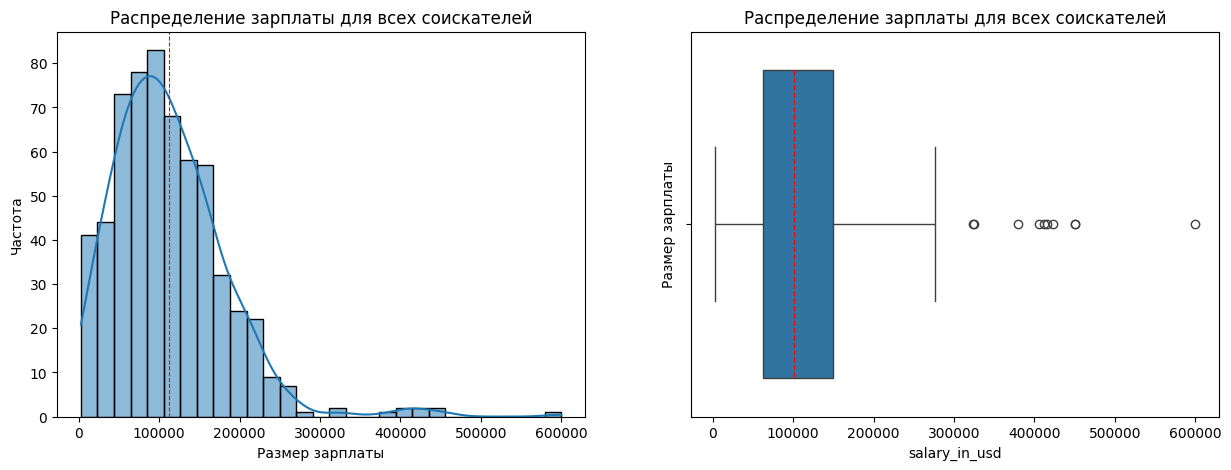

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Частота')
axes[0].set_title('Распределение зарплаты для всех соискателей')
axes[0].axvline(df['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплаты')
axes[1].set_title('Распределение зарплаты для всех соискателей')

Распределение не является нормальным. Присутствуют выбросы. Медиана и среднее с виду похожи 

Выберем из датасета только те записи, которые относятся к работникам Data Scientist

In [137]:
data = df[df['job_title'] == 'Data Scientist']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 0 to 599
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          143 non-null    int64 
 1   work_year           143 non-null    int64 
 2   experience_level    143 non-null    object
 3   employment_type     143 non-null    object
 4   job_title           143 non-null    object
 5   salary              143 non-null    int64 
 6   salary_currency     143 non-null    object
 7   salary_in_usd       143 non-null    int64 
 8   employee_residence  143 non-null    object
 9   remote_ratio        143 non-null    int64 
 10  company_location    143 non-null    object
 11  company_size        143 non-null    object
 12  remote              143 non-null    int64 
dtypes: int64(6), object(7)
memory usage: 15.6+ KB


Посмотрим на распределение зарплат Data Scientist:

Text(0.5, 1.0, 'Распределение зарплаты для всех соискателей')

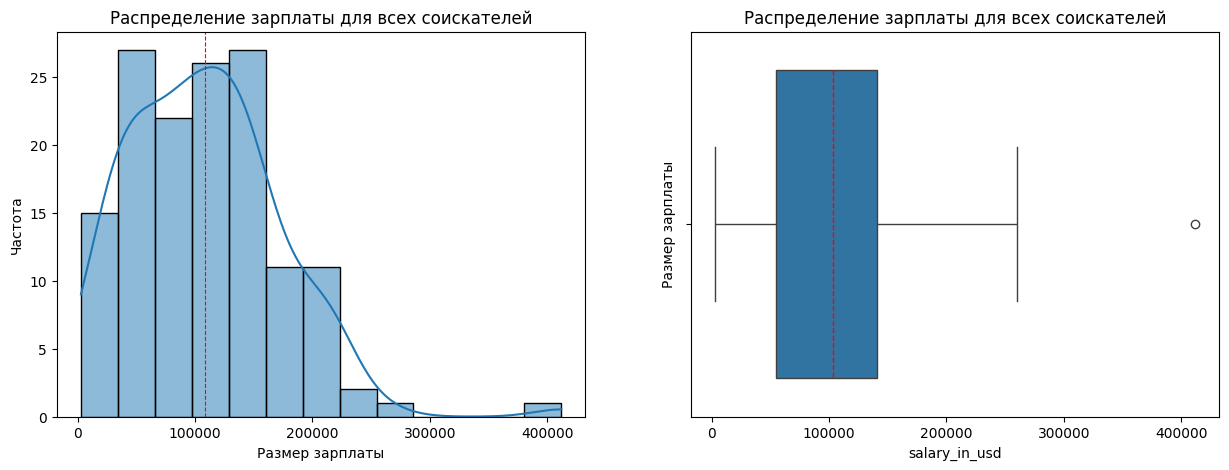

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Частота')
axes[0].set_title('Распределение зарплаты для всех соискателей')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплаты')
axes[1].set_title('Распределение зарплаты для всех соискателей')

Распределение все еще не похоже на нормальное

# 1. От каких факторов зависит зарплата Data Scientist?

## Зарплата Data Scientist в зависимости от опыта работы

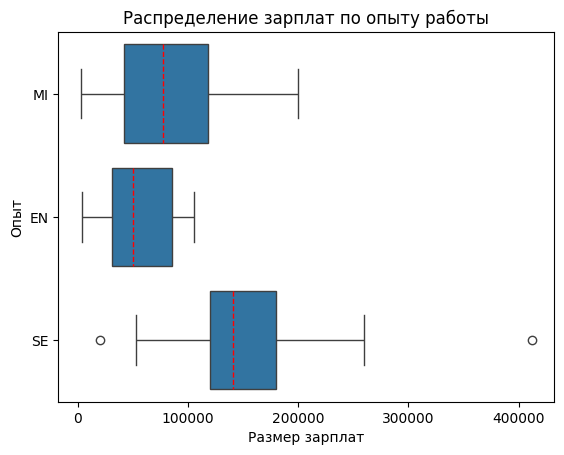

In [111]:
ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Опыт')
plt.title('Распределение зарплат по опыту работы')
plt.show()

Видно, что распределение зарплат для людей с разным опытом работы отличается. Проверим статистически.

Нулевая гипотеза: зарплата не зависит от опыта работы.

У нас три независимых группы.

**Создадим функции для принятия решения**

In [112]:
# задаём уровень значимости
alpha = 0.05 

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.


In [114]:
# значения страховых выплат
salary_en = data.loc[data['experience_level']=='EN', 'salary_in_usd']
salary_mi = data.loc[data['experience_level']=='MI', 'salary_in_usd']
salary_se = data.loc[data['experience_level']=='SE', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для EN:')
result = stats.shapiro(salary_en)
decision_normality(result[1])

print('Для MI:')
result = stats.shapiro(salary_mi)
decision_normality(result[1])


print('Для SE:')
result = stats.shapiro(salary_se)
decision_normality(result[1])


Для EN:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для MI:
p-value = 0.178
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для SE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [115]:
# проводим тест
_, p = stats.kruskal(salary_en, salary_mi, salary_se)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**:

### <font color='red'>Зарплата Data Scientist зависит от опыта работы</font>

## Распределение зарплат по типу трудоустройства

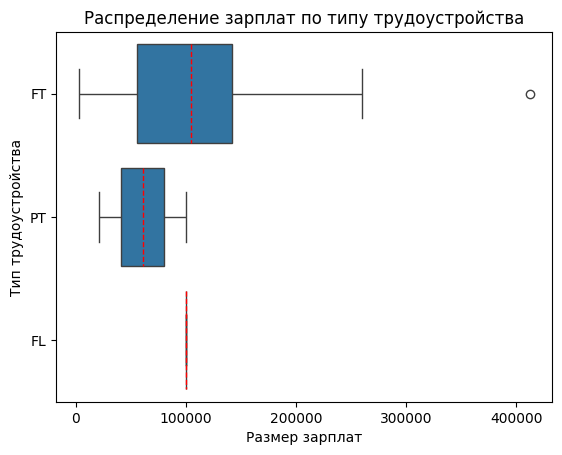

In [116]:
ax = sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Тип трудоустройства')
plt.title('Распределение зарплат по типу трудоустройства')
plt.show()

Распределение выглядит различным для разных типов трудоустройства. Однако проверим величину выборок

In [124]:
salary_ft = data.loc[data['employment_type']=='FT', 'salary_in_usd']
salary_pt = data.loc[data['employment_type']=='PT', 'salary_in_usd']
salary_fl = data.loc[data['employment_type']=='FL', 'salary_in_usd']

print("FT")
salary_ft.info()

print('PT')
salary_pt.info()

print('FL')
salary_fl.info()


FT
<class 'pandas.core.series.Series'>
Index: 140 entries, 0 to 599
Series name: salary_in_usd
Non-Null Count  Dtype
--------------  -----
140 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
PT
<class 'pandas.core.series.Series'>
Index: 2 entries, 62 to 487
Series name: salary_in_usd
Non-Null Count  Dtype
--------------  -----
2 non-null      int64
dtypes: int64(1)
memory usage: 32.0 bytes
FL
<class 'pandas.core.series.Series'>
Index: 1 entries, 488 to 488
Series name: salary_in_usd
Non-Null Count  Dtype
--------------  -----
1 non-null      int64
dtypes: int64(1)
memory usage: 16.0 bytes


**Вывод**:

### <font color='red'>Почти все Data Scientist в выборке работают полный рабочий день.</font>

## Распределение зарплат по годам

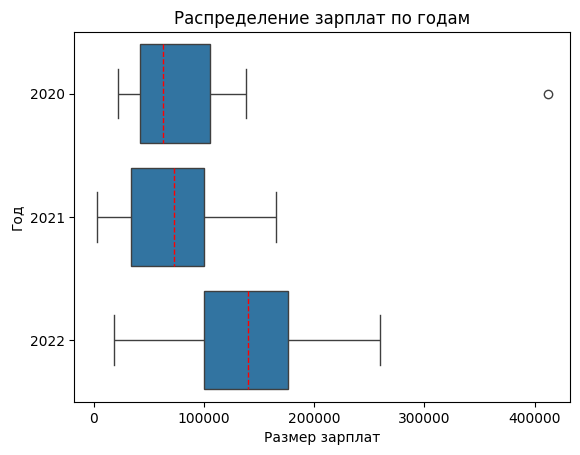

In [125]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Год')
plt.title('Распределение зарплат по годам')
plt.show()

Судя по графику, с течением времени зарплата увеличивается. Проверим статистически.

Нулевая гипотеза: зарплата не зависит от года.

Проверим нормальность распределения признака

In [126]:
salary_2020 = data.loc[df['work_year']==2020, 'salary_in_usd']
salary_2021 = data.loc[df['work_year']==2021, 'salary_in_usd']
salary_2022 = data.loc[df['work_year']==2022, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])


print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [127]:
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**:

### <font color='red'>Зарплата зависит от года</font>

## Распределение зарплат по работе удаленно/в офисе

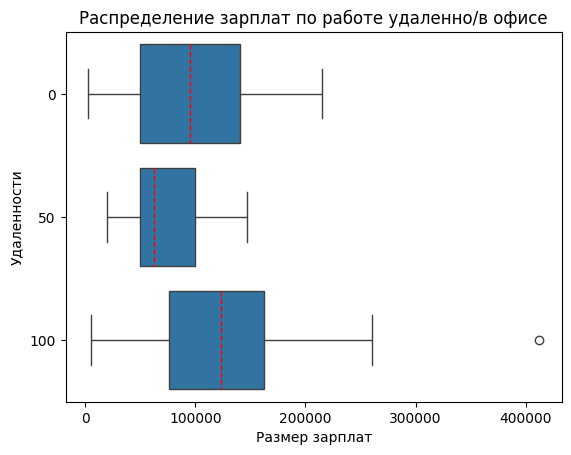

In [128]:
ax = sns.boxplot(data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Удаленности')
plt.title('Распределение зарплат по работе удаленно/в офисе')
plt.show()

Распределение отличается в зависимости от степени удаленности работы. Проверим это статистически.

Нулевая гипотеза: зарплата не зависит от того, удаленная работа или нет. 

Проверим нормальность распределения признаков.

In [129]:
salary_r0 = data.loc[df['remote_ratio']==0, 'salary_in_usd']
salary_r50 = data.loc[df['remote_ratio']==50, 'salary_in_usd']
salary_r100 = data.loc[df['remote_ratio']==100, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для 0:')
result = stats.shapiro(salary_r0)
decision_normality(result[1])

print('Для 50:')
result = stats.shapiro(salary_r50)
decision_normality(result[1])


print('Для 100:')
result = stats.shapiro(salary_r100)
decision_normality(result[1])

Для 0:
p-value = 0.363
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 50:
p-value = 0.482
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 100:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [130]:
_, p = stats.kruskal(salary_r0, salary_r50, salary_r100)
decision_hypothesis(p)

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**:

### <font color='red'>Зарплата зависит от того, удаленная работа или нет</font>

## Распределение зарплат в зависимости от того, в одной ли стране находятся сотрудник и его компания

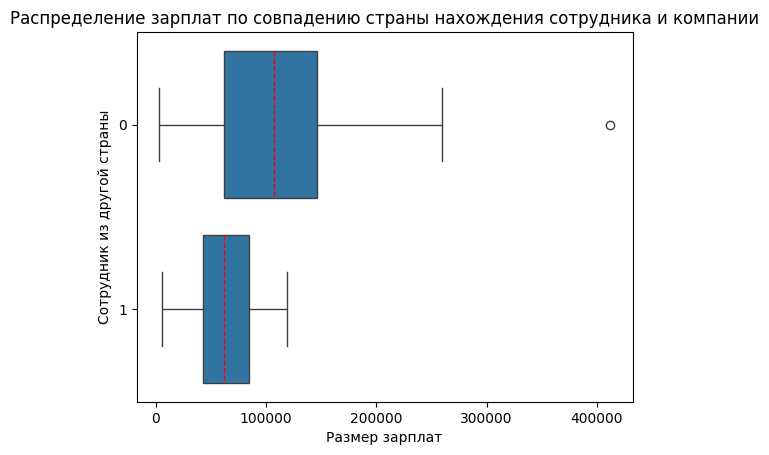

In [131]:
ax = sns.boxplot(data, x='salary_in_usd', y='remote', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Сотрудник из другой страны')
plt.title('Распределение зарплат по совпадению страны нахождения сотрудника и компании')
plt.show()

Кажется, зарплата зависит от того, в разных ли странах находятся сотрудник и компания. Проверим это статистически.

Нулевая гипотеза: зарплата не зависит от того, в одной ли стране находятся сотрудник и компания.

Проверим признаки на нормальность распределения. 

In [132]:
salary_r00 = data.loc[df['remote']==0, 'salary_in_usd']
salary_r01 = data.loc[df['remote']==1, 'salary_in_usd']



# проводим тест Шапиро-Уилка
print('Для 0:')
result = stats.shapiro(salary_r00)
decision_normality(result[1])

print('Для 1:')
result = stats.shapiro(salary_r01)
decision_normality(result[1])


Для 0:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 1:
p-value = 0.850
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [133]:
# проводим тест
_, p = stats.mannwhitneyu(salary_r00, salary_r01, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**:

### <font color='red'>Зарплата зависит от того, в одной стране находятся компания и работник, или нет</font>

## Распределение зарплат по размеру компании

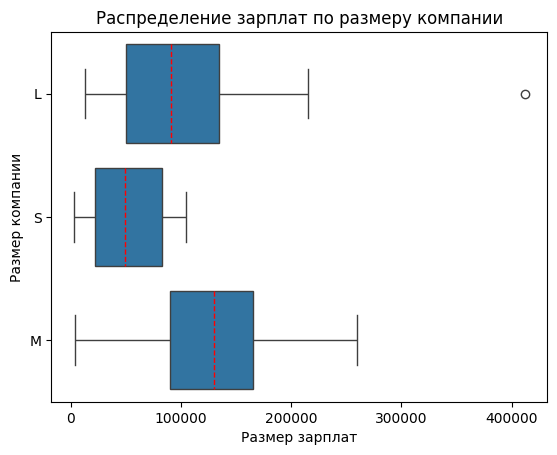

In [134]:
ax = sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Размер компании')
plt.title('Распределение зарплат по размеру компании')
plt.show()

Судя по графику, размер зарплаты зависит от размера компании. Проверим это статистически.

Нулевая гипотеза: размер зарплаты не зависит от размера компании.

Проверим нормальность распределения признаков

In [135]:
salary_s = data.loc[df['company_size']=='S', 'salary_in_usd']
salary_m = data.loc[df['company_size']=='M', 'salary_in_usd']
salary_l = data.loc[df['company_size']=='L', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_m)
decision_normality(result[1])


print('Для L:')
result = stats.shapiro(salary_l)
decision_normality(result[1])

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [136]:
_, p = stats.kruskal(salary_s, salary_m, salary_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**:

### <font color='red'>Зарплата зависит размера компании</font>

## <u>Итого:</u>

Статистически верно, что зарплата специалиста Data Scientist зависит от следующих факторов:
- Опыт работы
- Год работы
- Удаленная работа или нет
- В одной стране находится компания и сотрудник или нет
- Размер компании. 
 

# Поиск ответов на вопросы HR агентства.

## 1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Выделим группы для тестирования и проверим, нормально ли они распределены:

In [76]:
salary_sс_2020 = df[(df['job_title']=='Data Scientist') & (df['work_year']==2020)]['salary_in_usd']
salary_sc_2021 = df[(df['job_title']=='Data Scientist') & (df['work_year']==2021)]['salary_in_usd']
salary_sc_2022 = df[(df['job_title']=='Data Scientist') & (df['work_year']==2022)]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_sс_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_sc_2021)
decision_normality(result[1])


print('Для 2022:')
result = stats.shapiro(salary_sc_2022)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Для положительного ответа на вопрос необходимо, чтобы выполнялись два условия:

1. Зарплаты за 2021 год больше, чем за 2020
2. Зарплаты за 2022 год больше, чем за 2021

Проверим сначала первое утверждение.

<b>Нулевая гипотеза:</b> зарплаты в 2021 меньше либо равны зарплатам в 2020 году

<b>Альтернативная гипотеза:</b> зарплаты в 2021 году больше, чем в 2020.

Выберем подходящий статистический тест:

* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [79]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sс_2020, salary_sc_2021, alternative='less')
decision_hypothesis(p)

p-value = 0.685
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## Вывод: 

### <font color='red'>Зарплата Data Scientist в 2021 году меньше либо равна зарплатам Data Scientist в 2020 году. 
### <b><u>Ежегодного роста зарплат не наблюдается</u></b></font>

Проверим однако зарплаты в 2022 и 2021 году.

<b>Нулевая гипотеза:</b> Зарплаты в 2022 году меньше либо равны зарплатам в 2021 году.

<b>Альтернативная гипотеза:</b> Зарплаты в 2022 году больше, чем в 2021 году (левостороннняя)

Выберем статистический тест:

* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Нам подходит двухвыборочный t-критерий.

Однако сначала надо сравнить дисперсии в выбранных группах:

In [80]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_sc_2021, salary_sc_2022)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.445
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [81]:
# проводим тест на сравнение средних в группах
_, p = stats.ttest_ind(salary_sc_2021, salary_sc_2022, alternative='less', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод:

### <font color='red'>Хотя ежегодного роста зарплат у Data Scientist не наблюдается, зарплаты в 2022 году в среднем больше зарплат в 2021.</font>

## 2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Есть три варианта соотношения: зарплата Data Scientist может быть равна, меньше или больше зарплаты Data Engineer.

Разобьем нашу проверку на две части: 

- Нулевая гипотеза №1: зарплаты равны. 
- Нулевая гипотеза №2 (проверяем только при опровержении гипотезы выше): зарплата Data Scientist меньше либо равна зарплате Data Engineer (тогда альтернативная гипотеза будет левосторонней)

Выборку для зарплат Data Scientist 2022 года мы сделали, отвечая на предыдущий вопрос, и эта выборка распределена нормально. Сделаем выборку для зарплат Data Engineer в 2022 году и проверим, нормально ли ее распределение.

In [82]:
salary_en_2022 = df[(df['job_title']=='Data Engineer') & (df['work_year']==2022)]['salary_in_usd']

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary_en_2022)
decision_normality(result[1])

p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Проверим нулевую гипотезу №1.

Подберем статистический тест:

* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [85]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sc_2022, salary_en_2022, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.155
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


##  Вывод:

### <font color = 'red'><u><b>Статистически зарплаты для роли Data Scientist и для роли Data Engineer не отличаются.</u></b></font> 

# 3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров? 

Для ответа на этот вопрос необходимо ответить на несколько подвопросов.

Для начала проверим следующую нулевую гипотезу:

1. Нулевая гипотеза: зарплата Data Scientist не зависит от размера компании. 


Выделим выборки и проверим распределение данных в них на нормальность.

In [86]:
salary_sс_s = df[(df['job_title']=='Data Scientist') & (df['company_size']=='S')]['salary_in_usd']
salary_sc_m = df[(df['job_title']=='Data Scientist') & (df['company_size']=='M')]['salary_in_usd']
salary_sc_l = df[(df['job_title']=='Data Scientist') & (df['company_size']=='L')]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_sс_s)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_sc_m)
decision_normality(result[1])


print('Для L:')
result = stats.shapiro(salary_sc_l)
decision_normality(result[1])

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Проверим нашу первую гипотезу. Подберем статистический тест:

* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**



In [88]:
_, p = stats.kruskal(salary_sс_s, salary_sc_m, salary_sc_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Делаем вывод, что <font color = 'red'>размер зарплаты Data Scientist зависит от размера компании. </font>

Проверим теперь следующую нулевую гипотезу: 

- Размер зарплаты в маленьких и средних компаниях равен. 

Выберем статистический тест:

* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Нам подходит двухвыборочный t-критерий.

Однако сначала надо сравнить дисперсии в выбранных группах:

In [89]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_sс_s, salary_sc_m)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.025
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


In [90]:
# проводим тест на сравнение средних в группах
_, p = stats.ttest_ind(salary_sс_s, salary_sc_m, alternative='two-sided', equal_var=False)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Предположим теперь, что зарплата в маленьких фирмах меньше, чем зарплата в средних.

- Нулевая гипотеза: зарплата в маленьких фирмах больше или равна зарплате в средних
- Альтернативная гипотеза: зарплата в средних фирмах больше, чем в маленьких (левосторонняя)

Проверяем гипотезу при помощи двухвыборочного t-критерия:

In [91]:
# проводим тест на сравнение средних в группах
_, p = stats.ttest_ind(salary_sс_s, salary_sc_m, alternative='less', equal_var=False)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### <font color = 'red'>зарплата Data Scientist в компаниях среднего размера больше, чем в компаниях маленького размера </font> 

Проверим теперь, равны ли зарплаты в средних и больших компаниях.

Нулевая гипотеза: зарплаты в средних и больших компаниях у специалистов Data Scientist равны.

Выберем статистический тест: 

* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [92]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sc_m, salary_sc_l, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.011
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Предположим теперь, что зарплата в средних фирмах меньше, чем зарплата в крупных.

- Нулевая гипотеза: зарплата в средних фирмах больше или равна зарплате в крупных
- Альтернативная гипотеза: зарплата в крупных фирмах больше, чем в средних (левосторонняя)

Для проверки гипотезы используем U-критерий Манна — Уитни.

In [93]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sc_m, salary_sc_l, alternative='less')
decision_hypothesis(p)

p-value = 0.994
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### <font color = 'red'>зарплата Data Scientist в компаниях среднего размера больше, чем в компаниях большого размера </font> 

Теперь надо сравнить компании маленького и большого размера. 

- Нулевая гипотеза: размеры зарплат в маленьких фирмах и в крупных равны.

Для проверки гипотезы используем U-критерий Манна — Уитни, так как распределение зарплат для крупных компаний отлично от нормального

In [94]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sс_s, salary_sc_l, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Предположим теперь, что зарплата в маленьких фирмах меньше, чем зарплата в крупных.

- Нулевая гипотеза: зарплата в маленьких фирмах больше или равна зарплате в крупных
- Альтернативная гипотеза: зарплата в крупных фирмах больше, чем в маленьких (левосторонняя)

Для проверки гипотезы используем U-критерий Манна — Уитни.

In [95]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sс_s, salary_sc_l, alternative='less')
decision_hypothesis(p)

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод

### Зарплата Data Scientist зависит от размера фирмы следующим образом: 
 
### <font color = 'red'><b><u>зарплата в средних фирмах > зарплаты в крупных фирмах > зарплаты в маленьких фирмах </b></u></font>

# 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Необходимо определить наличие связи между двумя категориальными признаками. 

Для начала построим таблицу сопряженности

In [98]:
# делаем отдельную колонку для признака профессии
df['DS or DE'] = df['job_title'].apply(lambda x: 1 if x == 'Data Scientist' or x == 'Data Engineer' else 0)

df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote,DS or DE
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,0,1
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,0,0
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,0,0
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,0,0
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,0,0


In [99]:
#таблица сопряженности
table = pd.crosstab(df['DS or DE'], df['company_size'])
table

company_size,L,M,S
DS or DE,,,
0,116,160,56
1,82,166,27


Условие применимости критерия хи-квадрат — наличие как минимум пяти объектов в каждой ячейке - выполняется. Поэтому можем использовать для проверки наличия связи критерий хи-квадрат.

Нулевая гипотеза: связи не имеется.

Альтернативная гипотеза: между признаками есть связь.

Проведем тест.

In [100]:
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p)

p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод:

### <font color = 'red'><b><u>Между наличием должности Data Scientist или Data Engineer и размером компании есть связь.</b></u></font>

# <u>Итого:</u>

- Несмотря на то, что зарплаты Data Scientist в 2022 году больше, чем в 2021 году, ежегодного роста зарплаты не наблюдается.
- Зарплаты Data Scientist и Data Engineer в 2022 году статистически равны.
- Зарплата Data Scientist зависит от размера фирмы следующим образом: зарплата в средних фирмах > зарплаты в крупных фирмах > зарплаты в маленьких фирмах.
- Наличие должности Data Scientist или Data Engineer взаимосвязано с размером компании.